In [204]:
from sklearn.linear_model import LinearRegression,Lasso
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error,mean_absolute_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt

In [311]:
df = pd.read_csv("../data/raw/co2/CapeGrim_CH4.csv",usecols=[0,4])
df1 = pd.read_csv("../data/raw/co2/CapeGrim_CO2.csv",usecols=[0,4])
df2 = pd.read_csv("../data/raw/co2/CapeGrim_N2O.csv",usecols=[0,4])
df = df.groupby('Year').mean().reset_index()
df1 = df1.groupby('Year').mean().reset_index()
df2 = df2.groupby('Year').mean().reset_index()
aus_df = (df.merge(df1,on='Year',how='left')).merge(df2,on='Year',how='left')
aus_df.iloc[1,3] = 300.515
aus_df.iloc[4,3] = 303.72
aus_df.iloc[40,3] = 332.608
aus_df.loc[41] = ''
aus_df.iloc[41,[0,1,2,3]]= [1981,aus_df.iloc[2,1]+20.64,aus_df.iloc[2,2]+1.768,aus_df.iloc[2,3]+0.44]
aus_df.loc[42] = ''
aus_df.iloc[42,[0,1,2,3]] = [1982,aus_df.iloc[2,1]+20.64*2,\
    aus_df.iloc[2,2]+1.768*2,aus_df.iloc[2,3]+0.44*2]
aus_df.loc[43] = ''
aus_df.iloc[43,[0,1,2,3]] = [1983,aus_df.iloc[2,1]+20.64*3,\
    aus_df.iloc[2,2]+1.768*3,aus_df.iloc[2,3]+0.44*3]
aus_df = aus_df.sort_values('Year').reset_index(drop=True)
aus_df.head()

,Year,CH4(ppb),CO2(ppm),N2O(ppb)
0,1978,1488.05,333.476,299.37
1,1979,1495.1,335.26,300.515
2,1980,1540.1,336.526,301.66
3,1981,1560.74,338.294,302.1
4,1982,1581.38,340.062,302.54


In [312]:
#global anomalies Australia
aus_sum = pd.read_csv('../data/cleaned/australia_extreme_summary.csv')
aus_sum = aus_sum[aus_sum['Year']>1977]
cols = ['avg_temp', 'max_temp', 'min_temp', 'rainfall_anom']
aus_sum = aus_sum[['Year', 'avg_temp', 'max_temp', 'min_temp', 'rainfall_anom']].\
    reset_index(drop=True)
aus_sum.head()

,Year,avg_temp,max_temp,min_temp,rainfall_anom
0,1978,-0.31,-0.50,-0.12,51.35
1,1979,0.37,0.44,0.30,-14.23
2,1980,0.74,0.93,0.54,-36.28
3,1981,0.27,0.18,0.36,61.31
4,1982,-0.04,0.21,-0.29,-50.90


In [313]:
final_df = aus_df.merge(aus_sum,on='Year',how='left')
final_df.head()

,Year,CH4(ppb),CO2(ppm),N2O(ppb),avg_temp,max_temp,min_temp,rainfall_anom
0,1978,1488.05,333.476,299.37,-0.31,-0.50,-0.12,51.35
1,1979,1495.1,335.26,300.515,0.37,0.44,0.30,-14.23
2,1980,1540.1,336.526,301.66,0.74,0.93,0.54,-36.28
3,1981,1560.74,338.294,302.1,0.27,0.18,0.36,61.31
4,1982,1581.38,340.062,302.54,-0.04,0.21,-0.29,-50.90


## [Arima for greenhouse gases predictions]

In [314]:
df=final_df.copy()
df.head()

,Year,CH4(ppb),CO2(ppm),N2O(ppb),avg_temp,max_temp,min_temp,rainfall_anom
0,1978,1488.05,333.476,299.37,-0.31,-0.50,-0.12,51.35
1,1979,1495.1,335.26,300.515,0.37,0.44,0.30,-14.23
2,1980,1540.1,336.526,301.66,0.74,0.93,0.54,-36.28
3,1981,1560.74,338.294,302.1,0.27,0.18,0.36,61.31
4,1982,1581.38,340.062,302.54,-0.04,0.21,-0.29,-50.90


<AxesSubplot:xlabel='Year'>

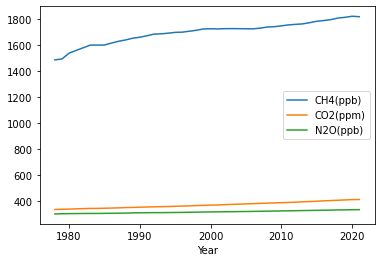

In [315]:
df = df[['Year','CH4(ppb)','CO2(ppm)','N2O(ppb)']]
df.set_index('Year',inplace=True)
df.plot()

In [318]:
# grid search ARIMA parameters for time series
import warnings
from math import sqrt
from pandas import read_csv
from pandas import datetime
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
 
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	train_size = int(len(X) * 0.66)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit()
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	rmse = sqrt(mean_squared_error(test, predictions))
	return rmse
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					rmse = evaluate_arima_model(dataset, order)
					if rmse < best_score:
						best_score, best_cfg = rmse, order
				except:
					continue
	print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
 
# evaluate parameters
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
for c in ['CH4(ppb)','CO2(ppm)','N2O(ppb)']:
    series = df[c]
    print(c)
    evaluate_models(series.values, p_values, d_values, q_values)

CH4(ppb)
Best ARIMA(0, 2, 1) RMSE=4.522
CO2(ppm)
Best ARIMA(2, 2, 0) RMSE=0.551
N2O(ppb)
Best ARIMA(10, 0, 2) RMSE=0.268


In [326]:
#Best ARIMA(0, 2, 1) RMSE=4.522 for df['CH4(ppb)']
#Best ARIMA(2, 2, 0) RMSE=0.551 for df['CO2(ppm)']
#Best ARIMA(10, 0, 2) RMSE=0.268 for df['N2O(ppb)']
model_df = pd.DataFrame(df['CO2(ppm)'].astype(float))
model = ARIMA(model_df, order=(2, 2, 0))
model_fit = model.fit()
start = len(df['CO2(ppm)'])+1
end = start+78
pred = model_fit.predict(start=start,end=end)

model_df2 = pd.DataFrame(df['CH4(ppb)'].astype(float))
model2 = ARIMA(model_df2, order=(0, 2, 1))
model_fit2 = model2.fit()
start2 = len(df['CH4(ppb)'])+1
end2 = start2+78
pred2 = model_fit2.predict(start=start2,end=end2)

model_df3 = pd.DataFrame(df['N2O(ppb)'].astype(float))
model3 = ARIMA(model_df3, order=(10, 0, 2))
model_fit3 = model3.fit()
start3 = len(df['N2O(ppb)'])+1
end3 = start3+78
pred3 = model_fit3.predict(start=start3,end=end3)
pred_df = pd.DataFrame({"Year":np.arange(2022,2101),"CH4(ppb)":pred2,
    "CO2(ppm)":pred,"N2O(ppb)":pred3})
pred_df.head()

,Year,CH4(ppb),CO2(ppm),N2O(ppb)
45,2022,1830.371049,414.290678,333.808196
46,2023,1834.996573,415.738439,334.695951
47,2024,1839.622098,417.409906,335.403317
48,2025,1844.247622,419.150056,336.114695
49,2026,1848.873147,420.750422,336.968081


In [329]:
df.reset_index(inplace=True)
pred_df2 = pd.concat([df,pred_df])
pred_df2.head()

,Year,CH4(ppb),CO2(ppm),N2O(ppb)
0,1978,1488.05,333.476,299.37
1,1979,1495.1,335.26,300.515
2,1980,1540.1,336.526,301.66
3,1981,1560.74,338.294,302.1
4,1982,1581.38,340.062,302.54


In [330]:
final_df2 = final_df[['Year','avg_temp','max_temp','min_temp','rainfall_anom']]
f_df = pred_df2.merge(final_df2,on='Year',how='left')
f_df.head()

,Year,CH4(ppb),CO2(ppm),N2O(ppb),avg_temp,max_temp,min_temp,rainfall_anom
0,1978,1488.05,333.476,299.37,-0.31,-0.50,-0.12,51.35
1,1979,1495.1,335.26,300.515,0.37,0.44,0.30,-14.23
2,1980,1540.1,336.526,301.66,0.74,0.93,0.54,-36.28
3,1981,1560.74,338.294,302.1,0.27,0.18,0.36,61.31
4,1982,1581.38,340.062,302.54,-0.04,0.21,-0.29,-50.90


## [Lineair regression for avg temp, max & min temp and rainfall anom]

In [332]:
m_df = f_df.dropna()
m_df.set_index('Year',inplace=True)
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
for c in ['avg_temp','max_temp','min_temp','rainfall_anom']:
    series = m_df[c]
    print(c)
    evaluate_models(series.values, p_values, d_values, q_values)
# columns = ['avg_temp','max_temp','min_temp']
# X = m_df[['CH4(ppb)','CO2(ppm)','N2O(ppb)']]
# pred_dic = {'avg_temp':[],'max_temp':[],'min_temp':[]}
# to_predict = f_df[f_df['Year']>2020][['CH4(ppb)','CO2(ppm)','N2O(ppb)']]
# for col in columns:
#     y = m_df[col].to_numpy().reshape(-1,1)
#     X_train,X_test,y_train,y_test = train_test_split(X,y)
#     model = LinearRegression()
#     model.fit(X_train,y_train)
#     pred = model.predict(X_test)
#     pred_dic[col] = (model.predict(to_predict)).ravel()
#     print('#'*10)
#     print(col)
#     print(model.score(X_train,y_train))
#     print(model.score(X_test,y_test))
#     print('Mean Absolute Error:', mean_absolute_error(y_test, pred))
#     print('Mean Squared Error:', mean_squared_error(y_test, pred))
#     print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, pred)))

avg_temp
Best ARIMA(1, 2, 2) RMSE=0.396
max_temp
Best ARIMA(1, 2, 2) RMSE=0.533
min_temp
Best ARIMA(0, 2, 2) RMSE=0.358
rainfall_anom
Best ARIMA(1, 0, 2) RMSE=92.857


In [339]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt

warnings.simplefilter('ignore')

# Common code for display result
def show_graph(df1,df2,title):
    data = pd.concat([df1, df2])
    data.reset_index(inplace=True, drop=True)
    for col in data.columns:
        if col.lower().startswith('pred'):
            data[col].plot(label=col,linestyle="dotted")
        else:
            data[col].plot(label=col)
    plt.title(title)
    plt.legend()
    plt.show()

In [340]:
from statsmodels.tsa.ar_model import AutoReg
from random import random

def AR_model(train,test,c):
    # fit model
    model = AutoReg(train, lags=1)
    model_fit = model.fit()
    # make prediction
    yhat=model_fit.predict(len(train), len(train) + len(test) - 1)
    res=pd.DataFrame({"Pred":yhat, f'{c}':test.values})
    return res
for c in ['avg_temp','max_temp','min_temp','rainfall_anom']:
    X = m_df[c]
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    df_ret = AR_model(train, test,c)
    show_graph(train, df_ret, "Autoregression (AR)")

AttributeError: 'int' object has no attribute 'lower'

In [81]:
#global data projections
final_df.to_csv('../data/cleaned/global_projection.csv',index=False)